In [1]:
from gymnasium.wrappers import TimeLimit
from env_hiv import HIVPatient

env = TimeLimit(
    env=HIVPatient(domain_randomization=True), max_episode_steps=200
)  # The time wrapper limits the number of steps in an episode at 200.

In [2]:
print(env.observation_space,env.observation_space.shape[0])
print(env.action_space,env.action_space.n)

Box(-inf, inf, (6,), float32) 6
Discrete(4) 4


In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import copy

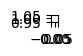

In [4]:
plt.figure(1,(0.1,0.1))
plt.plot(1)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from tqdm import trange

In [6]:
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = int(capacity) # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled
        self.device = device
    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(np.array(x)).to(self.device), list(zip(*batch))))
    def __len__(self):
        return len(self.data)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeedQNetwork_Plus(nn.Module):
    def __init__(self, env, thresholds):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        width = 128

        # Calculate the number of additional features
        self.num_binary_vars = state_dim  # One binary variable per feature
        self.num_multiplications = int(state_dim * (state_dim - 1) / 2)  # Combination of pairs

        # Updated input dimension to account for the new features
        updated_input_dim = state_dim + self.num_binary_vars + self.num_multiplications

        self.bn1 = nn.BatchNorm1d(updated_input_dim)
        self.fc1 = nn.Linear(updated_input_dim, width)
        
        self.fc2 = nn.Linear(width, width)
        self.bn2 = nn.BatchNorm1d(width)
        self.fc3 = nn.Linear(width, action_dim)

        # Thresholds for creating binary variables
        self.thresholds = torch.tensor(thresholds, dtype=torch.float32)

    def forward(self, x):
        # Create binary variables
        binary_vars = (x < self.thresholds).float()

        # Calculate feature multiplications
        multiplications = []
        for i in range(x.size(1) - 1):
            for j in range(i + 1, x.size(1)):
                multiplications.append(x[:, i] * x[:, j])
        multiplications = torch.stack(multiplications, dim=1)

        # Concatenate original features, binary variables, and multiplications
        #print(x.shape,binary_vars.shape,multiplications.shape)
        x = torch.cat([x, binary_vars, multiplications], dim=1)

        # Forward pass
        #x = self.bn1(x)
        x = self.fc1(x)
        x = F.gelu(x)

        x = self.fc2(x)
        #x = self.bn2(x)
        x = F.gelu(x)
        
        x = self.fc3(x)
        return x

In [8]:
tresholds = [400000,10000,1000,1000,200000,1000]
DQN = DeedQNetwork_Plus(env,tresholds)

In [9]:
DQN(torch.tensor([[1,1,1,1,1,1],[2,2,2,2,2,2]]))

tensor([[ 0.1254, -0.2629, -0.0295,  0.5754],
        [ 0.0350,  0.1271,  0.3632,  0.3062]], grad_fn=<AddmmBackward0>)

In [10]:

class DeedQNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        width = 20

        self.fc1 = nn.Linear(state_dim, width)
        self.bn1 = nn.BatchNorm1d(width) 
        self.fc2 = nn.Linear(width, width)
        self.bn2 = nn.BatchNorm1d(width)
        self.fc3 = nn.Linear(width, action_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.gelu(x)
        x = self.fc3(x)
        return x

def greedy_action(network, state):
    device = "cuda" if next(network.parameters()).is_cuda else "cpu"
    with torch.no_grad():
        network.eval()
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).item()
    
class ProjectAgent:
    def __init__(self, env):
        device = "cpu"
        self.network = DeedQNetwork(env).to(device)

    def act(self, observation, use_random=False):
        return greedy_action(self.network, observation)  # Greedy action based on the network

    def save(self, path):
        torch.save(self.network.state_dict(), path)

    def load(self, path):
        self.network.load_state_dict(torch.load(path))

DQN = DeedQNetwork(env)

In [11]:
class dqn_agent:
    def __init__(self, config, model):
        device = "cuda" if next(model.parameters()).is_cuda else "cpu"
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'], device)
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.model = model 
        self.target_model = copy.deepcopy(model)
        self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])

        self.track_loss = 0
        self.track_actions = [0, 0, 0, 0]
        self.current_reward = 0.03
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def act(self, state):
        return greedy_action(self.model, state)
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            self.model.train()
            X, A, R, Y, D = self.memory.sample(self.batch_size)

            # 2
            # Get the indices of the max predicted Q values from the main model for the next state
            with torch.no_grad():
                _, next_state_actions = self.model(Y).max(1, keepdim=True)
            
            # Get the Q values from the target model for the next state and the chosen action by the main model
            QYmax = self.target_model(Y).gather(1, next_state_actions).squeeze().detach()
            
            # 1
            #QYmax = self.target_model(Y).max(1)[0].detach()
            
            update = torch.addcmul(R, 1-D, QYmax, value=self.gamma)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))/self.current_reward
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.track_loss += loss.item()
            #self.track_actions += np.sum(QYmax.numpy(),axis=0)
    
    def train(self, env, max_episode):
        episode_return = []
        episode_grad = []
        episode_loss = []
        episode_actions = []
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0
        self.model_path_name = f"best_{datetime.now().strftime('%Y%m%d_%H%M')}.pth"

        while episode < max_episode:
            try:
                if step%17 == 0:
                    print("Step :",step,
                        "| Episode :",episode,
                        "| Grad :",'{:1.7f}'.format(self.mean_grad()),
                        end="\r")
                # update epsilon
                if step > self.epsilon_delay:
                    epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)

                # select epsilon-greedy action
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = greedy_action(self.model, state)
                self.track_actions[action] += 1

                # step
                next_state, reward, done, trunc, _ = env.step(action)
                reward = reward/1000000
                self.memory.append(state, action, reward, next_state, done)
                episode_cum_reward += reward

                # train
                self.gradient_step()

                # next transition
                step += 1
                if done or trunc:
                    episode += 1
                    print("Episode ", '{:3d}'.format(episode), 
                        ", epsilon ", '{:6.2f}'.format(epsilon), 
                        ", memory ", '{:5d}'.format(len(self.memory)), 
                        ", episode return ",'1e{:1.2f}'.format(np.log10(episode_cum_reward)+6),
                        ", gradient ", '{:1.7f}'.format(self.mean_grad()), "g",
                        sep='')
                    state, _ = env.reset()
                    episode_return.append(episode_cum_reward)
                    episode_grad.append(self.mean_grad())
                    episode_loss.append(self.track_loss)
                    episode_actions.append(self.track_actions)

                    self.track_loss = 0
                    self.track_actions = [0, 0, 0, 0]
                    self.current_reward = episode_cum_reward/200
                    episode_cum_reward = 0                    

                    if max(episode_return) == episode_return[-1]:
                        torch.save(self.model.state_dict(), os.path.join("model_dir", self.model_path_name))
                        print("Best Agent Saved ! With a return of",'1e{:1.2f}'.format(np.log10(episode_return[-1])+6))
                    
                    self.update_target_model()
                else:
                    state = next_state
            except:
                return episode_return, episode_grad, episode_loss, episode_actions
            
        return episode_return, episode_grad, episode_loss, episode_actions

    def mean_grad(self):
        try:
            gradients = []
            for param in self.model.parameters():
                if param.grad is not None:
                    gradients.append(param.grad.view(-1))
            gradients = torch.cat(gradients)
            mean_grad = gradients.mean()
            
            return mean_grad.item()
        except:
            return 0
    
    def show_run(self, env, force_path=None):
        # Initialize environment
        state, _ = env.reset()
        actions, states, rewards = [], [state], []
        if force_path is None:
            self.model.load_state_dict(torch.load(os.path.join("model_dir", self.model_path_name)))
        else:
            self.model.load_state_dict(torch.load(os.path.join("model_dir", force_path)))
        
        while True:
            # Select the best action for the current state
            action = greedy_action(self.model, state)
            actions.append(action)
            
            # Execute the selected action
            state, reward, done, trunc, _ = env.step(action)
            states.append(state)
            rewards.append(reward)
            
            # Break if the episode is done
            if trunc:
                break
        
        print("Total reward", sum(rewards))
        # Plotting
        fig, axs = plt.subplots(3, 1, figsize=(10, 10))
        
        # Plot states
        states = np.array(states)
        for i in range(states.shape[1]):
            axs[0].plot(states[:, i], label=f"State {i+1}")
        axs[0].set_title("States over Time")
        axs[0].legend()
        
        # Plot actions
        axs[1].plot(actions, 'ro-', label="Action")
        axs[1].set_title("Actions over Time")
        axs[1].legend()
        
        # Plot rewards
        axs[2].plot(rewards, 'g^-', label="Reward")
        axs[2].set_title("Rewards over Time")
        axs[2].legend()
        
        plt.tight_layout()
        plt.show()

        return states

In [12]:
tresholds = [800000,500,1100,30,1000,20000]
DQN = DeedQNetwork_Plus(env,tresholds)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DQN config
config = {'nb_actions': env.action_space.n,
          'learning_rate': 0.0001,
          'gamma': 0.90,
          'buffer_size': 40000, ###
          'epsilon_min': 0.01,
          'epsilon_max': 1,
          'epsilon_decay_period': 20000,
          'epsilon_delay_decay': 1000,
          'batch_size': 512}

# Train agent
agent = dqn_agent(config, DQN)
episode_return, episode_grad, episode_loss, episode_actions = agent.train(env, 1000)

Episode   1, epsilon   1.00, memory   200, episode return 1e6.75, gradient 0.0000000g
Best Agent Saved ! With a return of 1e6.75
Episode   2, epsilon   1.00, memory   400, episode return 1e6.87, gradient 0.0000000g
Best Agent Saved ! With a return of 1e6.87
Episode   3, epsilon   1.00, memory   600, episode return 1e7.08, gradient -0.0007443g
Best Agent Saved ! With a return of 1e7.08
Episode   4, epsilon   1.00, memory   800, episode return 1e6.95, gradient 0.0005868g
Episode   5, epsilon   1.00, memory  1000, episode return 1e6.86, gradient 0.0000707g
Episode   6, epsilon   0.99, memory  1200, episode return 1e6.96, gradient 0.0001934g
Episode   7, epsilon   0.98, memory  1400, episode return 1e6.86, gradient -0.0002318g
Episode   8, epsilon   0.97, memory  1600, episode return 1e6.86, gradient -0.0001083g
Episode   9, epsilon   0.96, memory  1800, episode return 1e7.04, gradient 0.0007049g
Episode  10, epsilon   0.95, memory  2000, episode return 1e7.00, gradient 0.0008805g
Episode 

C:\Users\adhem\AppData\Local\Temp\ipykernel_17868\3613436368.py:9: RuntimeWarning: divide by zero encountered in log10
  axes[2].plot(np.log10(episode_loss))


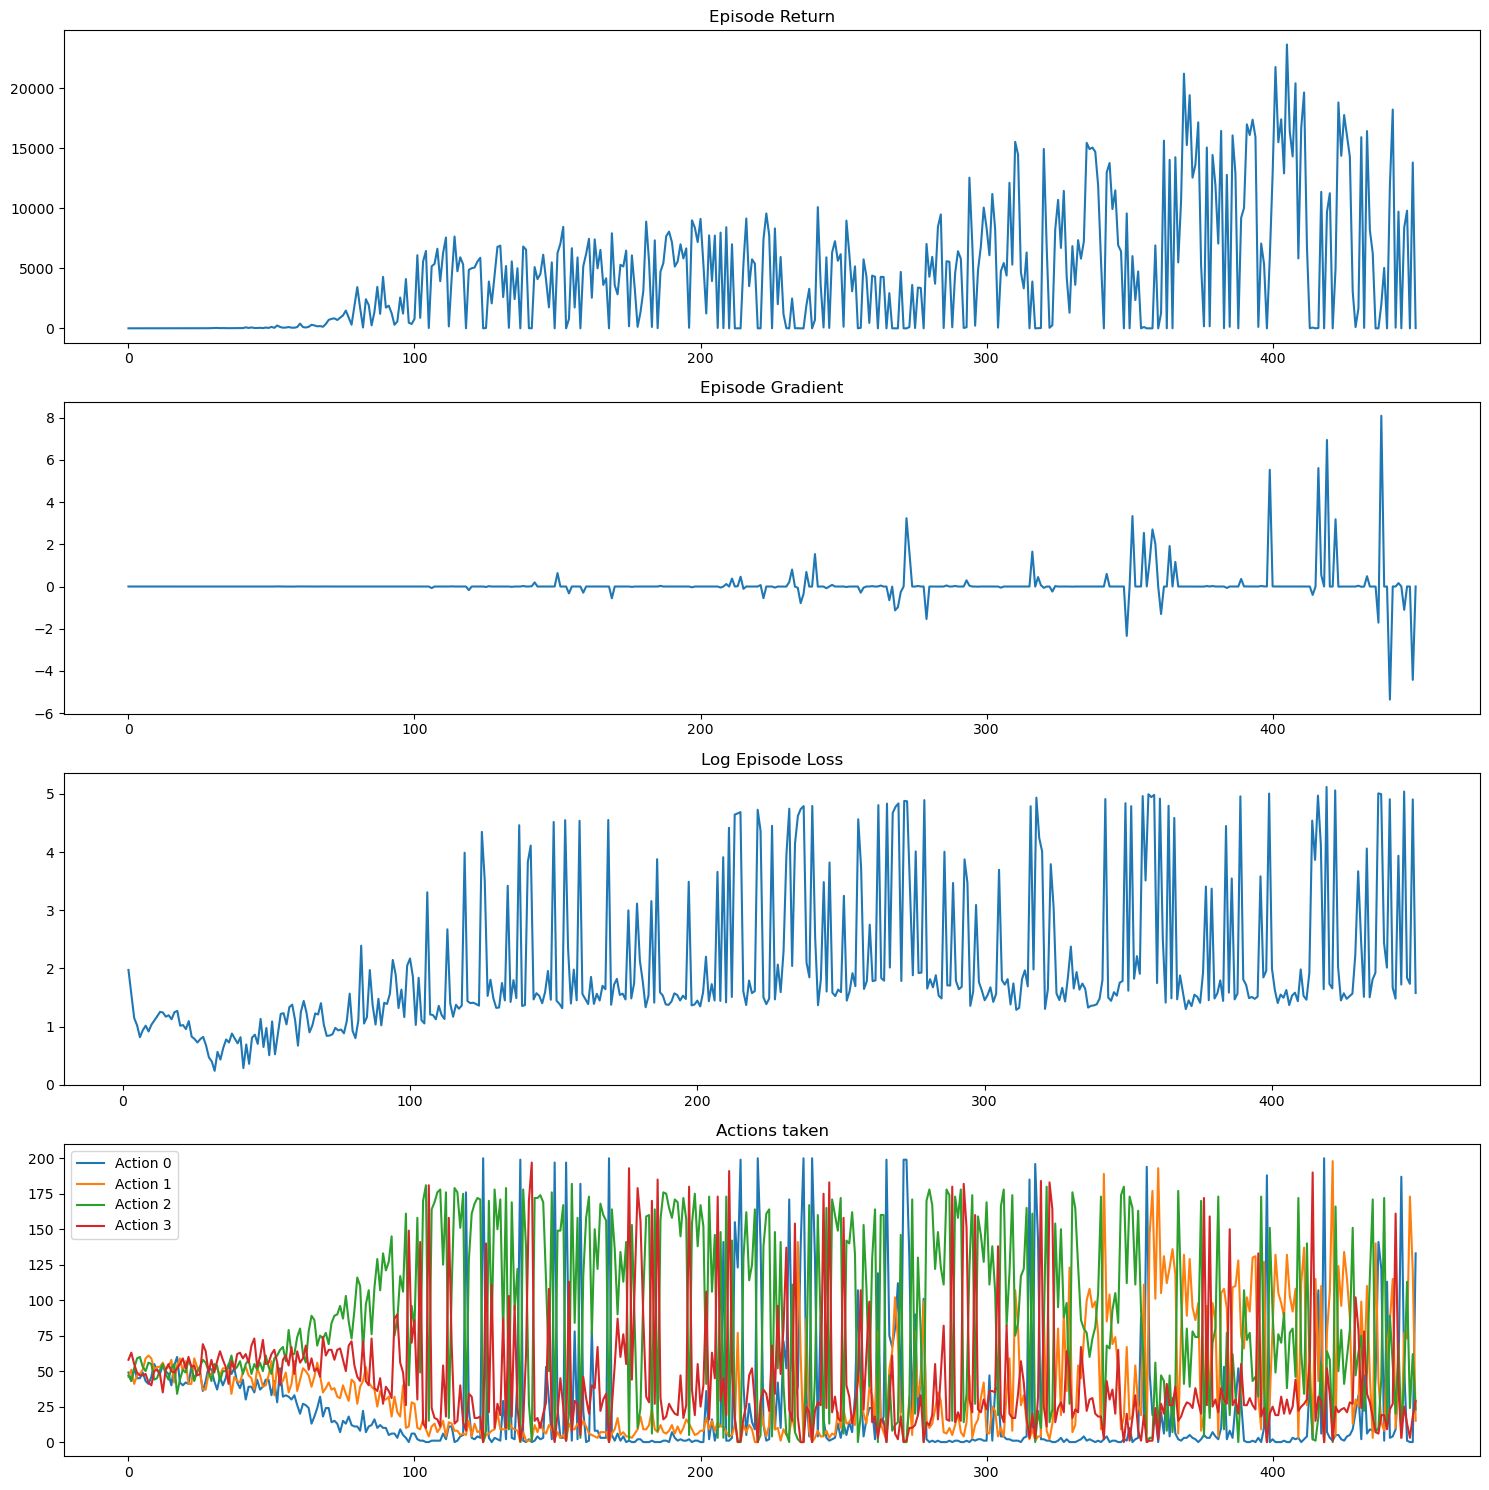

In [14]:
f, axes = plt.subplots(4, 1, figsize=(15, 15))  # Corrected line here

axes[0].plot(episode_return)
axes[0].set_title('Episode Return')

axes[1].plot(episode_grad)
axes[1].set_title('Episode Gradient')

axes[2].plot(np.log10(episode_loss))
axes[2].set_title('Log Episode Loss')

axes[3].plot(np.array(episode_actions)[:,0], label="Action 0")
axes[3].plot(np.array(episode_actions)[:,1], label="Action 1")
axes[3].plot(np.array(episode_actions)[:,2], label="Action 2")
axes[3].plot(np.array(episode_actions)[:,3], label="Action 3")
axes[3].set_title('Actions taken')
axes[3].legend()

plt.tight_layout()  # Optional: Improves the spacing between plots
plt.show()

Total reward 16298217093.815718


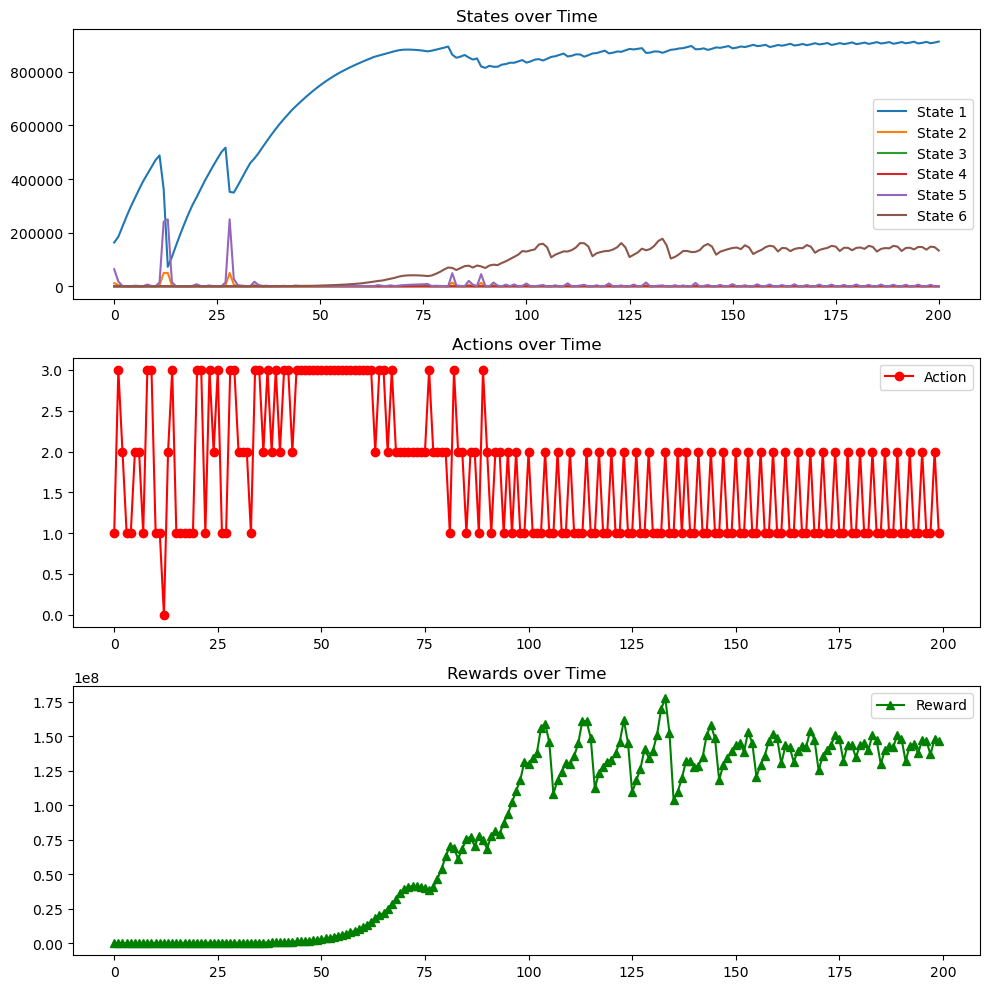

In [15]:
states = agent.show_run(env)

Total reward 16298217093.815718


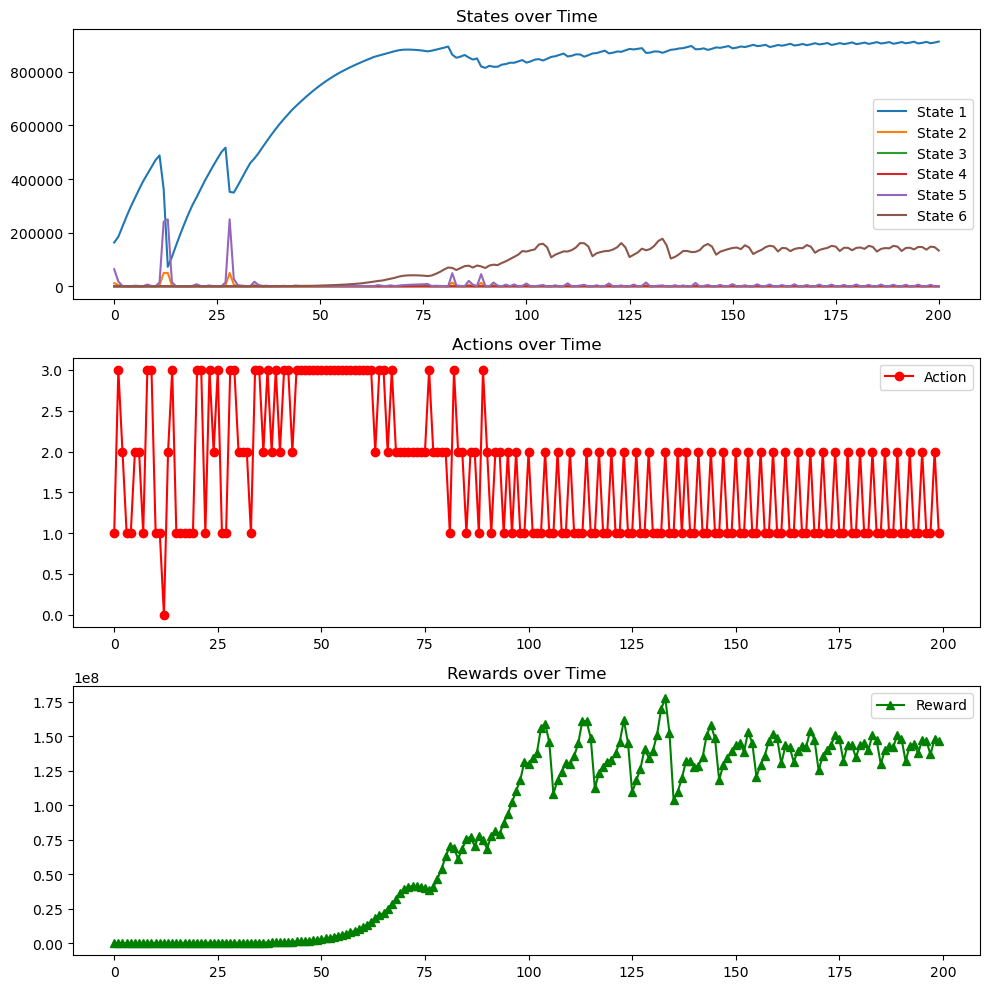

In [ ]:
states = agent.show_run(env)

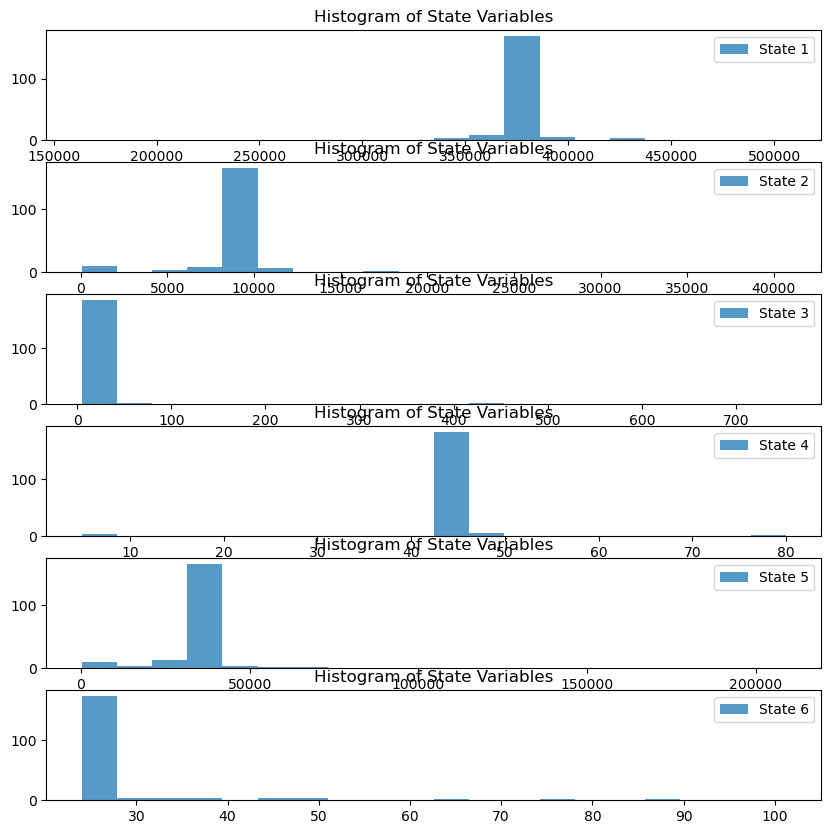

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(10, 10))

for i in range(states.shape[1]):
    axs[i].hist(states[:, i], bins=20, alpha=0.75, label=f"State {i+1}")
    axs[i].set_title("Histogram of State Variables")
    axs[i].legend()

In [ ]:
states[:, 0]

array([163573.        , 202147.57680694, 240892.91214946, 277894.41264717,
       313103.85915838, 346593.02576993, 378409.69854073, 408045.56129439,
       436482.86335519, 463783.98454415, 489143.56519849, 513463.02420718,
       536837.61110764, 559192.25705555, 578385.3882218 , 596471.55187721,
       615338.35292309, 633612.22439648, 651082.39561217, 667734.05185851,
       683565.45947412, 698576.04620429, 712755.98299628, 726076.97890674,
       739027.86480213, 751283.60371577, 763099.90400599, 774238.9420188 ,
       784487.31822898, 794427.43162488, 803618.90378127, 812549.36030841,
       820716.05537529, 828691.50659216, 836589.2524299 , 843825.48606506,
       850829.3648241 , 857096.39537452, 863221.5918359 , 869373.46322741,
       874882.27550616, 880258.05029802, 885654.03674681, 890490.7179796 ,
       895207.9950516 , 899320.74096375, 903436.95443276, 907714.2479206 ,
       911587.81583496, 915432.53948216, 918922.97100333, 922433.78527589,
       925667.87308269, 9

In [ ]:
torch.save(agent.target_model.state_dict(), os.path.join("model_dir", "Fuck.pth"))

In [ ]:
!python main.py

In [ ]:

tresh_1 = [3432807.680391572, 1e8, 1e9, 1e10, 2e10, 5e10]
tresh_2 = [1e10, 2e10, 5e10]

score_file = "./score.txt"

with open(score_file) as f:
    lines = f.readlines()

score_1 = float(lines[0][:-2])
score_2 = float(lines[1])

print("Score 1",round(np.log10(score_1),3),round(score_1,3))
print("Score 2",round(np.log10(score_2),3),round(score_2,3))

def calculate_passed_thresholds(score, thresholds):
    return sum(score >= t for t in thresholds)

# Calculate surpassed thresholds for each score
passed_tresh_1 = calculate_passed_thresholds(score_1, tresh_1)
passed_tresh_2 = calculate_passed_thresholds(score_2, tresh_2)


total_score = passed_tresh_1 + passed_tresh_2  # Adjusted scoring logic

print()
print(str(total_score)+"/9",)
print()

passed_tresh_1, passed_tresh_2

Score 1 6.986 9691878.835
Score 2 10.156 14331362855.304

2/9



(1, 1)